In [24]:
import numpy as np
from numpy import arccos, cos, sin, sqrt, arctan, tan
from numpy.linalg import norm
import numpy.typing as npt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Constants

In [25]:
MU_EARTH = 3.986004418e14   # Earth's gravitational parameter (mu) [m^3/s^2]
R_EARTH = 6378137.0         # Earth's equatorial radius [m]
AU = 1.495978707e11         # Astronomical unit [m]
P_SRP = 4.5398e-6           # Solar radiation pressure [N/m^2]
J_2 = 1.08263e-3            # Earth's second zonal harmonics coefficient
# Values taken from MECH309 Final Project Specification
A_M = 1.0                   # Area to mass ratio [m^2/kg]
C_R = 1.08                  # Reflectivity coefficient
C_D = 3.46                  # Drag coefficient
# Values taken from Vallado, Curtis, and JPL
MU_MOON = 4.9048695e12      # Moon's gravitational parameter (mu) [m^3/s^2]
MU_SUN = 1.32712440018e20   # Sun's gravitational parameter (mu) [m^3/s^2]

## Relation between ECI position and velocity, and Keplerian elements

Are provided the functions to convert:
- ECI position and velocity to the keplerian set of elements: ```keplerian_elements_to_eci```.
- Keplerian elements to ECI position and velocity: ```eci_to_orbital_elements```.
- Rotation matrix to convert a vector expressed in the ECI frame to the LVLH frame: ```rotation_matrix_eci_to_lvlh```.
- Rotation matrix to convert a vector expressed in the perifocal frame to the ECI frame: ```rotation_matrix_p_to_eci```.

In [26]:
def rotation_matrix_eci_to_lvlh(raan: float, i: float, u: float) -> npt.NDArray:
    """
    Computes the Direction Cosine Matrix (DCM) to transform a vector expressed in the ECI frame to the LVLH frame.
    R_eci2lvlh = R3(u) R1(i) R3(raan)

    Parameters:
        i          : Inclination (rad)
        raan       : Right Ascension of Ascending Node (rad)
        u          : Argument of latitude (rad) (argument of perigee + true anomaly)

    Returns:
        R_eci2lvlh : DCM from ECI to LVLH (3,3)
    """
    R_raan = np.array([[cos(raan), sin(raan), 0], [-sin(raan), cos(raan), 0], [0, 0, 1]])

    R_i = np.array([[1, 0, 0], [0, cos(i), sin(i)], [0, -sin(i), cos(i)]])

    R_u = np.array([[cos(u), sin(u), 0], [-sin(u), cos(u), 0], [0, 0, 1]])

    return R_u @ R_i @ R_raan


def rotation_matrix_p_to_eci(raan: float, i: float, argp: float) -> npt.NDArray:
    """
    Computes the Direction Cosine Matrix (DCM) to transform a vector expressed in the perifocal frame to the ECI frame.
    R_p2eci = R3(raan)^T R1(i)^T R3(argp)^T

    Parameters:
        i      : Inclination (rad)
        raan   : Right Ascension of Ascending Node (rad)
        argp   : Argument of perigee (rad)

    Returns:
        R_p2eci : DCM from perifocal to ECI frame (3,3)
    """
    R_raan_T = np.array([[cos(raan), -sin(raan), 0], [sin(raan), cos(raan), 0], [0, 0, 1]])

    R_i_T = np.array([[1, 0, 0], [0, cos(i), -sin(i)], [0, sin(i), cos(i)]])

    R_argp_T = np.array([[cos(argp), -sin(argp), 0], [sin(argp), cos(argp), 0], [0, 0, 1]])

    return R_raan_T @ R_i_T @ R_argp_T


def keplerian_elements_to_eci(
    a: float, e: float, i: float, raan: float, argp: float, nu: float, mu: float = MU_EARTH
) -> tuple[npt.NDArray, npt.NDArray]:
    """
    Convert Keplerian elements to ECI position and velocity vectors.

    Parameters:
        a    : Semi-major axis (m)
        e    : Eccentricity
        i    : Inclination (rad)
        raan : Right Ascension of Ascending Node (rad)
        argp : Argument of Periapsis (rad)
        nu   : True Anomaly (rad)
        mu   : Gravitational parameter (Earth's the default)

    Returns:
        r_eci : Position vector in ECI frame (m) (3,)
        v_eci : Velocity vector in ECI frame (m/s) (3,)
    """

    # Distance at current true anomaly
    r_norm = a * (1 - e**2) / (1 + e * cos(nu))

    # Perifocal coordinates
    r_perifocal = np.array([r_norm * cos(nu), r_norm * sin(nu), 0.0])

    h = sqrt(mu * a * (1 - e**2))  # specific angular momentum

    v_perifocal = np.array([-mu / h * sin(nu), mu / h * (e + cos(nu)), 0.0])

    # Rotation matrix

    R_p_to_eci = rotation_matrix_p_to_eci(raan, i, argp)

    # Convert to ECI frame
    r_eci = R_p_to_eci @ r_perifocal
    v_eci = R_p_to_eci @ v_perifocal

    return r_eci, v_eci


def eci_to_keplerian_elements(r: npt.NDArray, v: npt.NDArray, mu=MU_EARTH) -> tuple[float, float, float, float, float, float]:
    """
    Convert ECI position and velocity vectors to Keplerian elements.

    Parameters:
        r    : Position vector (m)
        v    : Velocity vector (m/s)
        mu   : Gravitational parameter (Earth's the default)

    Returns:
        a     : Semi-major axis (m)
        e     : Eccentricity
        i     : Inclination (rad)
        raan  : RAAN (rad)
        argp  : Argument of Periapsis (rad)
        nu    : True Anomaly (rad)
    """
    r_norm = np.linalg.norm(r)
    v_norm = np.linalg.norm(v)

    # Specific angular momentum
    h_vec = np.cross(r, v)
    h = np.linalg.norm(h_vec)

    # Inclination
    i = arccos(h_vec[2] / h)

    # Node vector
    K = np.array([0, 0, 1])
    n_vec = np.cross(K, h_vec)
    n = np.linalg.norm(n_vec)

    # Eccentricity vector
    e_vec = (1 / mu) * ((v_norm**2 - mu / r_norm) * r - np.dot(r, v) * v)
    e = np.linalg.norm(e_vec)

    # RAAN
    if n != 0:
        raan = arccos(n_vec[0] / n)
        if n_vec[1] < 0:
            raan = 2 * np.pi - raan
    else:
        raan = 0.0

    # Argument of periapsis
    if n != 0 and e != 0:
        argp = arccos(np.dot(n_vec, e_vec) / (n * e))
        if e_vec[2] < 0:
            argp = 2 * np.pi - argp
    else:
        argp = 0.0

    # True anomaly
    if e != 0:
        nu = arccos(np.dot(e_vec, r) / (e * r_norm))
        if np.dot(r, v) < 0:
            nu = 2 * np.pi - nu
    else:
        nu = 0.0

    # Semi-major axis from vis-viva
    a = 1 / ((2 / r_norm) - (v_norm**2 / mu))

    return a, e, i, raan, argp, nu

## Kepler's equation

Is provided the function to compute the eccentric anomaly for a given true anomaly ($\nu$) and eccentricity ($e$): ```eccentric_anomaly```

Implement in ```solve_kepler``` an algorithm to evaluate the eccentric anomaly for a given mean anomaly ($M$) and orbital eccentricity ($e$):
$$M=E-e\,\sin{E}$$

In [27]:
def eccentric_anomaly(nu: float, e: float) -> float:
    """
    Compute the eccentric from the true anomaly.

    Inputs:
        nu    : True anomaly (rad)
        e     : Eccentricity

    Returns:
        E     : Eccentric anomaly (rad)
    """
    return arctan(sqrt((1 - e) / (1 + e)) * tan(nu / 2)) * 2


def solve_kepler(M: float, e: float, tol: float = 1e-10, max_iter: int = 50) -> float:
    """
    Solve Kepler's equation M = E - e sin E for eccentric anomaly E using Newton's method.

    Inputs:
      M        : Mean anomaly (rad)
      e        : Eccentricity
      tol      : Tolerance on the outputed E
      max_iter : Maximum number of iterations

    Returns:
      E        : Eccentric anomaly (rad)
    """
    f = lambda E: E - ((E - e * np.sin(E) - M)/(1 - e * np.cos(E))) # Newton's method iteration function
    n = 0 # iteration counter

    E_0 = 0.0 # initial guess
    E_1 = f(E_0) # initialize first iteration

    while np.abs(E_1 - E_0) > tol and n <= max_iter:
        E_0 = E_1
        E_1 = f(E_0)
        n += 1

    return E_1

## Initial Value Problem (IVP)

### Fixed-step Runge-Kutta Methods

Implement in:
- ```rk2_propagation``` Algorithm 8.3 of the lecture notes, that is Runge-Kutta method of order 2 for IVP
- ```rk4_propagation``` Algorithm 8.4 of the lecture notes, that is Runge-Kutta method of order 4 for IVP

Is provided a wrap-up function of ```solve_ip``` from the ```scipy``` library to numerically propagate a system of differential equations given an initial value.

In [28]:
def rk2_propagation(f, t0: float, tf: float, y0: npt.NDArray, h: float) -> tuple[npt.NDArray, npt.NDArray]:
    """
    Numerically integrates (propagate), using Runge-Kutta method of order 2, a system of ODEs given an initial value:

        dy / dt = f(t, y)
        y(t0) = y0

    Inputs:
        f      : Differential function to integrate f(t,y)
        t0     : Initial time (s)
        tf     : Final time (s)
        y0     : Initial state vector (n,)
        h      : Fixed time step (s)

    Returns:
        y      : Array of integrated (propagated) states (N,n)
        t      : Array of time associated to the propagated states (N,)
    """
    N = int(np.ceil((tf - t0) / h))  # number of steps

    # allocate arrays
    y = np.zeros((N+1, len(y0)))
    t = np.zeros(N+1)

    # initial conditions
    y[0] = y0
    t[0] = t0

    for i in range(N):
        ti = t[i]
        yi = y[i]

        k1 = f(ti, yi)
        k2 = f(ti + h/2, yi + (h/2)*k1)

        y[i+1] = yi + h*k2
        t[i+1] = ti + h

    return t, y

def rk4_propagation(f, t0: float, tf: float, y0: npt.NDArray, h: float) -> tuple[npt.NDArray, npt.NDArray]:
    """
    Numerically integrates (propagate), using Runge-Kutta method of order 4, a system of ODEs given an initial value:

        dy / dt = f(t, y)
        y(t0) = y0

    Inputs:
        f      : Differential function to integrate f(t,y)
        t0     : Initial time (s)
        tf     : Final time (s)
        y0     : Initial state vector (n,)
        h      : Fixed time step (s)

    Returns:
        y      : Array of integrated (propagated) states (N,n)
        t      : Array of time associated to the propagated states (N,)
    """

    N = int(np.ceil((tf - t0)/h))

    y = np.zeros((N+1, len(y0)))
    t = np.zeros(N+1)

    y[0] = y0
    t[0] = t0

    for i in range(N):
        k1 = h*f(t[i], y[i])
        k2 = h*f(t[i] + h/2, y[i] + k1/2)
        k3 = h*f(t[i] + h/2, y[i] + k2/2)
        k4 = h*f(t[i] + h, y[i] + k3)
        y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4)/6.0
        t[i+1] = t[i] + h

    return t, y



def solve_ivp_propagation(f, t_span: npt.NDArray, y0: npt.NDArray, rtol=1e-9, atol=1e-12) -> tuple[npt.NDArray, npt.NDArray]:
    """
        Numerically integrates (propagate), using solve_ip from scipy, a system of ODEs given an initial value:

        dy / dt = f(t, y)
        y(t0) = y0

    Inputs:
        f      : Differential function to integrate f(t,y)
        y0     : Initial state vector [...]
        t_span : Array containing the times (s) at which to propagate
        rtol   : Relative tolerance for the numerical propagation
        atol   : Absolute tolerance for the numerical propagation

    Returns:
        y      : Array of integrated (propagated) states (N,n)
        t      : Array of time associated to the propagated states (N,)
    """

    solution = solve_ivp(f, [t_span[0], t_span[-1]], y0, t_eval=t_span, rtol=rtol, atol=atol)
    return solution.y.T, solution.t

## Two-body Problem (Keplerian motion)

### Force models: J2, atmospheric drag, third-body

Implement the perturbing accelerations in:
- ```a_j2```
- ```a_drag```
- ```a_3b```
- ```a_srp```

In [29]:
def a_j2(r_sc: npt.NDArray, mu: float, Re: float, J_2: float) -> npt.NDArray:
    """
    Third-body gravitational perturbation

    Inputs:
        r_sc    : Spacecraft position in the ECI frame (m) (3,)
        mu      : Earth's gravitational parameter (m^3/s^2)
        Re      : Earth's equatorial radius (m)
        J_2     : Earth's second zonal harmonics coefficient ()

    Returns:
        a_j2  : J2 perturbing acceleration vector in the ECi frame (m/s^2) (3,)
    """
    x, y, z = r_sc
    r = norm(r_sc)
    
    ax = x/r * (5 * (z/r)**2 - 1)
    ay = y/r * (5 * (z/r)**2 - 1)
    az = z/r * (5 * (z/r)**2 - 3)

    multiplier = 3.0/2.0 * J_2 * mu * Re**2 / r**4

    return multiplier * np.array([ax, ay, az])


def a_drag(v_sc: npt.NDArray, rho: float, Cd: float, A_m: float) -> npt.NDArray:
    """
    Atmospheric drag model: a = -0.5 * rho * v_rel^2 * Cd * A/m * norm(v_rel)

    Inputs:
        v_sc    : Spacecraft velocity in the ECI frame (m/s). For a simple model assume v_rel ~= v_sc (no atmosphere rotation) (3,)
        rho     : Atmospheric density at altitude (kg/m^3)
        Cd      : Drag coefficient
        A_m     : Area-to-mass ratio of the object (m^2/kg)

    Returns:
        a_drag  : Atmospheric drag perturbing acceleration vector in the ECi frame (m/s^2) (3,)
    """
    v_rel = v_sc
    mag_v_rel = norm(v_rel)

    multiplier = -0.5 * Cd * A_m * rho * mag_v_rel

    return multiplier * v_rel


def a_3b(r_sc: npt.NDArray, r_3b: npt.NDArray, mu_3b: float) -> npt.NDArray:
    """
    Third-body gravitational perturbation

    Inputs:
        r_sc    : Spacecraft position in the ECI frame (m) (3,)
        r_3b    : Third body position in the ECI frame (m) (3,)
        mu_3b   : Third body's gravitational parameter (m^3/s^2) (3,)

    Returns:
        a_3b  : Third body perturbing acceleration vector in the ECi frame (m/s^2) (3,)
    """
    diff_vector = r_3b - r_sc
    norm_diff_vector = norm(diff_vector)

    norm_r_3b = norm(r_3b)

    return mu_3b * (diff_vector/(norm_diff_vector**3.0) - r_3b/(norm_r_3b**3.0))

def a_srp(r_sc: npt.NDArray, r_sun: npt.NDArray, Cr: float, A_m: float, P_srp=P_SRP) -> npt.NDArray:
    """
    Simple cannonball SRP model.

    Inputs:
        r_sc    : Spacecraft position in the ECI frame (m) (3,)
        r_sun   : Sun position in the ECI frame (m) (3,)
        Cr      : Reflectivity coefficient
        A_m     : Area-to-mass ratio of the object (m^2/kg)
        au      : Astronaumical unit (m))
        P_srp   : Solar radiation pressure constant (N/m^2)

    Returns:
        a_srp  : SRP perturbing acceleration vector in the ECI frame (m/s^2) (3,)
    """
    diff_vector = r_sun - r_sc
    norm_diff_vector = norm(diff_vector)

    return P_srp * Cr * A_m * ((AU / norm_diff_vector)**2) * (diff_vector / norm_diff_vector)



Is provided the ```Perturbations``` class that includes simplified analytical models for the atmospheric density as well as the Sun and Moon positions in time (without the need for ephemerides).

In [30]:
class Perturbations:
    mu: float
    Re: float
    J_2: float | None
    A_m: float | None
    Cd: float | None
    Cr: float | None
    mu_sun: float | None
    mu_moon: float | None

    def __init__(
        self,
        mu: float = MU_EARTH,
        Re: float = R_EARTH,
        J_2: float | None = None,
        A_m: float | None = None,
        Cd: float | None = None,
        Cr: float | None = None,
        mu_sun: float | None = None,
        mu_moon: float | None = None,
    ):
        self.mu = mu
        self.Re = Re
        self.J_2 = J_2
        self.A_m = A_m
        self.Cd = Cd
        self.Cr = Cr
        self.mu_sun = mu_sun
        self.mu_moon = mu_moon

    def get_perturbing_acceleration(self, t: float, r_sc: npt.NDArray, v_sc: npt.NDArray) -> npt.NDArray:
        """
        Return the total perturbing acceleration in the ECI frame.

        Inputs:
            t       : Time (s)
            r_sc    : Spacecraft position in the ECI frame (m) (3,)
            v_sc    : Spacecraft velocity in the ECI frame (m) (3,)

        Returns:
            a_pert   : Total perturbing acceleration in the ECI frame
        """
        a_pert = np.array([0.0, 0.0, 0.0])

        if self.J_2 is not None:
            a_pert += a_j2(r_sc, self.mu, self.Re, self.J_2)

        if self.A_m is not None and self.Cr is not None:
            a_pert += a_srp(r_sc, self.get_r_sun(t), self.Cr, self.A_m)

        if self.A_m is not None and self.Cd is not None:
            a_pert += a_drag(v_sc, self.get_rho(r_sc), self.Cd, self.A_m)

        if self.mu_sun is not None:
            a_pert += a_3b(r_sc, self.get_r_sun(t), self.mu_sun)

        if self.mu_moon is not None:
            a_pert += a_3b(r_sc, self.get_r_moon(t), self.mu_moon)

        return a_pert

    def get_r_sun(self, t: float) -> npt.NDArray:
        """
        Simple circular orbit model of Earth around the Sun.
        
        Inputs:
            t       : time (s)

        Returns:
            r_sun  : Sun's position in the ECI frame (m) (3,)
        """
        # Mean motion of Earth around the Sun [rad/s]
        n = 2 * np.pi / (365.25 * 24 * 3600.0)

        # Mean longitude of the Sun (assuming t=0 at vernal equinox -> start of spring)
        lambda_s = n * t

        # Incline ecliptic plane with reference to the Earth's equatorial plane
        eps = np.deg2rad(23.44)
        r_sun_eci = AU * np.array([
            np.cos(lambda_s),
            np.sin(lambda_s) * np.cos(eps),
            np.sin(lambda_s) * np.sin(eps)
        ])

        return r_sun_eci

    def get_r_moon(self, t: float) -> npt.NDArray:
        """
        Simplified circular orbit with mean distance 384,400 km, period 27.32 days.
        
        Inputs:
            t       : time (s)

        Returns:
            r_moon  : Moon's position in the ECI frame (m) (3,)
        """
        # Mean motion of Moon around Earth [rad/s]
        n = 2 * np.pi / (27.32 * 24 * 3600.0)

        # Mean longitude (lambda_m(t=0) = pi -> arbitrary reference)
        lambda_m = n * t + np.pi

        # Mean Earth–Moon distance
        r = 384400e3  # m

        # Inclination of Moon's orbit (5.145°)
        i = np.deg2rad(5.145)

        # Assume ascending node fixed along x-axis
        r_moon_eci = r * np.array([
            np.cos(lambda_m),
            np.sin(lambda_m) * np.cos(i),
            np.sin(lambda_m) * np.sin(i)
        ])

        return r_moon_eci

    def get_rho(self, r_sc: npt.NDArray) -> float:
        """
        Exponential Atmospheric Model based on altitude.

        Reference:
            Vallado (2013) - Fundamentals of Astrodynamics and Applications, simplified model. (4th ed. Table 8-4)

        Inputs:
            r_sc : Spacecraft position vector in ECI (m) (3,)

        Returns:
            rho  : Atmospheric density (kg/m^3)
        """
        
        # Altitude [m]
        h = np.linalg.norm(r_sc) - self.Re
        h_km = h / 1000.0

        # Table values: base altitude [km], base density [kg/m^3], scale height [km]
        atmosphere_table = [
            [0,     1.225,        7.249],
            [25,    3.899e-2,     6.349],
            [30,    1.774e-2,     6.682],
            [40,    3.972e-3,     7.554],
            [50,    1.057e-3,     8.382],
            [60,    3.206e-4,     7.714],
            [70,    8.770e-5,     6.549],
            [80,    1.905e-5,     5.799],
            [90,    3.396e-6,     5.382],
            [100,   5.297e-7,     5.877],
            [110,   9.661e-8,     7.263],
            [120,   2.438e-8,     9.473],
            [130,   8.484e-9,     12.636],
            [140,   3.845e-9,     16.149],
            [150,   2.070e-9,     22.523],
            [180,   5.464e-10,    29.740],
            [200,   2.789e-10,    37.105],
            [250,   7.248e-11,    45.546],
            [300,   2.418e-11,    53.628],
            [350,   9.518e-12,    53.298],
            [400,   3.725e-12,    58.515],
            [450,   1.585e-12,    60.828],
            [500,   6.967e-13,    63.822],
            [600,   1.454e-13,    71.835],
            [700,   3.614e-14,    88.667],
            [800,   1.170e-14,    124.64],
            [900,   5.245e-15,    181.05],
            [1000,  3.019e-15,    268.00]
        ]

        # Above 1000 km, density is negligible
        if h_km > atmosphere_table[-1][0]:
            return 0.0

        # Find altitude band
        for idx, row in enumerate(atmosphere_table[:-1]):
            if h_km > row[0] and h_km <= atmosphere_table[idx+1][0]:
                break
        
        # Extract base parameters
        h0, rho0, H = atmosphere_table[idx]

        # Exponential decay
        rho = rho0 * np.exp(-(h_km - h0) / H)
        return rho


### Two-body equation in Cartesian coordinates

Implement in ```two_body_equation``` the two-body differential equation considering perturbations:
$$\ddot{\mathbf{r}} = -\frac{\mu_\text{earth}}{r^3}\mathbf{r} + \mathbf{a}_p$$
- What should be your vector state $\mathbf{y}$?
- How many dimensions does $\mathbf{y}$ have?

In [31]:
def two_body_equation(t: float, y: npt.NDArray, perturbations: Perturbations) -> npt.NDArray:
    """
    Keplerian motion ODE system in Cartesian coordinates.

    dy / dt = f(t, y)

    Inputs:
        t      : Time (s)
        y      : State vector (n,) - contains positon and velocity
        mu     : Gravitational parameter (m^3/s^2)
        perturbations: object containing the perturbations to include and associated parameters

    Returns:
        dydt   : State vector time derivative (n,)
    """
    pert_accel = perturbations.get_perturbing_acceleration(t, y[:3], y[3:])

    r = y[:3]
    norm_r = norm(r)

    vel = y[3:]
    accel = (-perturbations.mu * r / (norm_r**3)) + pert_accel

    dydt = np.zeros(6)
    dydt[:3] = vel
    dydt[3:] = accel

    return dydt

Implement in ```two_body_equation_with_stm``` the two-body differential equation considering perturbations along with the state transition matrix dynamics:
$$
\begin{align}
    \ddot{\mathbf{r}} &= -\frac{\mu_\text{earth}}{r^3}\mathbf{r} + \mathbf{a}_p \\
    \dot{\boldsymbol{\Phi}}(t, t_0) &= \frac{\partial \dot{\mathbf{y}}}{\partial \mathbf{y}}\,\boldsymbol{\Phi}(t, t_0)
\end{align}    
$$
- What should be your vector state $\mathbf{y}$?
- How many dimensions does $\mathbf{y}$ have?

In [32]:
def two_body_equation_with_stm(t: float, y: npt.NDArray, perturbations: Perturbations) -> npt.NDArray:
    """
    Keplerian motion ODE system in Cartesian coordinates.

    dy / dt = f(t, y)

    Inputs:
        t      : Time (s)
        y      : State vector (n,)
        mu     : Gravitational parameter (m^3/s^2)
        perturbations: object containing the perturbations to include and associated parameters

    Returns:
        dydt   : State vector time derivative (n,)
    """

    return NotImplementedError()

### Two-body equation in Keplerian elements

Implement ```propagate_keplerian_motion``` the closed-form solution of the unperturbed two-body problem expressing the mean anomaly ($M$) as a time ($t$) function:
$$M(t)=\sqrt{\frac{\mu_\text{earth}}{a^3}}(t-t_0)+M(t_0)$$

In [33]:
def propagate_keplerian_motion(t_span: npt.NDArray, y0: npt.NDArray, mu=MU_EARTH) -> tuple[npt.NDArray, npt.NDArray]:
    """
    Propagate orbital elements using Keplerian motion.

    Inputs:
        t_span : Array of target times (s) from initial time (N,)
        y0     : Initial state vector (n,)
        mu     : Gravitational parameter

    Returns:
        r      : Array (N,3) of position vectors in ECI frame (m)
        v      : Array (N,3) of velocity vectors in ECI frame (m/s)
    """
    r0 = y0[:3]
    v0 = y0[3:]
    r = np.zeros((len(t_span), 3))
    v = np.zeros((len(t_span), 3))
    r[0] = r0
    v[0] = v0

    a, e, inc, raan, argp, nu = eci_to_keplerian_elements(r0, v0, mu)
    E0 = eccentric_anomaly(nu, e)
    M0 = E0 - e * sin(E0)

    multiplier = sqrt(mu / (a**3))

    for k in range(1, len(t_span)):
        time_diff = t_span[k] - t_span[0]
        M = multiplier * time_diff + M0
        E = solve_kepler(M, e)

        cos_nu = (cos(E) - e)/(1 - (e * cos(E)))
        sin_nu = (sqrt(1 - e**2) * sin(E))/(1 - (e * cos(E)))
        nu = np.arctan2(sin_nu, cos_nu)

        r[k], v[k] = keplerian_elements_to_eci(a, e, inc, raan, argp, nu, mu)
        
    return r, v

### Gauss Variational Equations

Implement in ```gauss_variational``` the set of equations in Keplerian elements:
$$
\begin{align}
\frac{\text{d} a}{\text{d} t} &= \frac{2a^2}{h}\left[e \sin{\nu} \, p_r + \frac{h^2}{\mu r}\,p_s \right] \\
\frac{\text{d} e}{\text{d} t} &= \frac{h}{\mu}\sin{\nu}\,p_r+\frac{1}{\mu h}\left[ (h^2+\mu r)\cos{\nu}+\mu e r\right]p_s \\
\frac{\text{d} i}{\text{d} t} &= \frac{r}{h}\cos (\omega+\nu)\, p_w \\
\frac{\text{d} \Omega}{\text{d} t} &= \frac{r}{h}\frac{\sin (\omega+\nu)}{\sin i}\, p_w \\
\frac{\text{d} \omega}{\text{d} t} &= -\frac{1}{h e}\left[\frac{h^2}{\mu}\cos{\nu}\, p_r - \left(r+\frac{h^2}{\mu}\right)\sin{\nu}\, p_s \right] - \frac{r}{h}\frac{\sin (\omega+\nu)}{\tan i} p_w \\
\frac{\text{d} \nu}{\text{d} t} &= \frac{h}{r^2} - \left(\frac{\text{d} \omega}{\text{d} t} + \cos i \frac{\text{d} \Omega}{\text{d} t}\right)
\end{align}
$$
- What should be your vector state $\mathbf{y}$?
- How many dimensions does $\mathbf{y}$ have?

In [34]:
def gauss_variational(t: float, y: npt.NDArray, perturbations: Perturbations) -> npt.NDArray:
    """
    Keplerian motion ODE system in Keplerian elements.

    dy / dt = f(t, y)

    Inputs:
        t      : Time (s)
        y      : State vector (n,)
        perturbations: object containing the perturbations to include and associated parameters

    Returns:
        dydt   : State vector time derivative (n,)
    """
    a, e, inc, upper_omega, omega, nu = y

    h = sqrt(a * perturbations.mu * (1 - e**2))
    r = (a * (1 - e**2)) / (1 + (e * cos(nu)))
    r_sc, v_sc = keplerian_elements_to_eci(a, e, inc, upper_omega, omega, nu, perturbations.mu)

    pr, ps, pw = rotation_matrix_eci_to_lvlh(upper_omega, inc, omega + nu) @ perturbations.get_perturbing_acceleration(t, r_sc, v_sc)

    dadt = (2 * a**2 / h) * ((e * sin(nu) * pr) + (h**2 * ps / (perturbations.mu * r)))
    dedt = (h / perturbations.mu) * sin(nu) * pr + (1 / (perturbations.mu * h)) * ((h**2 + perturbations.mu * r) * cos(nu) + perturbations.mu * e * r) * ps
    dincdt = (r / h) * cos(omega + nu) * pw
    dupper_omegadt = (r / h) * sin(omega + nu) * pw / sin(inc)
    domegadt = (-1 / (h * e)) * ((h**2 / perturbations.mu) * cos(nu) * pr - (r + (h**2 / perturbations.mu)) * sin(nu) * ps) - ((r / h) * sin(omega + nu) * pw / tan(inc))
    dnudt = (h / r**2) - (domegadt + (cos(inc) * dupper_omegadt))

    dydt = np.array([dadt, dedt, dincdt, dupper_omegadt, domegadt, dnudt])

    return dydt

Implement a simpler version of Gauss variational equations when $p_r=p_s=p_w=0$ in ```unperturbed_gauss_variational```.
- What should be your vector state $\mathbf{y}$?
- How many dimensions does $\mathbf{y}$ have?

In [35]:
def unperturbed_gauss_variational(t: float, y: npt.NDArray, perturbations: Perturbations) -> npt.NDArray:
    """
    Keplerian motion ODE system in Keplerian coordinates.

    dy / dt = f(t, y)

    Inputs:
        t      : Time (s)
        y      : State vector (n,)
        perturbations: object containing the perturbations to include and associated parameters

    Returns:
        dydt   : State vector time derivative (n,)
    """
    a, e, inc, upper_omega, omega, nu = y

    h = sqrt(a * perturbations.mu * (1 - e**2))
    r = (a * (1 - e**2)) / (1 + (e * cos(nu)))
    r_sc, v_sc = keplerian_elements_to_eci(a, e, inc, upper_omega, omega, nu, perturbations.mu)

    pr, ps, pw = 0, 0, 0 # set unperturbed

    dadt = (2 * a**2 / h) * ((e * sin(nu) * pr) + (h**2 * ps / (perturbations.mu * r)))
    dedt = (h / perturbations.mu) * sin(nu) * pr + (1 / (perturbations.mu * h)) * ((h**2 + perturbations.mu * r) * cos(nu) + perturbations.mu * e * r) * ps
    dincdt = (r / h) * cos(omega + nu) * pw
    dupper_omegadt = (r / h) * sin(omega + nu) * pw / sin(inc)
    domegadt = (-1 / (h * e)) * ((h**2 / perturbations.mu) * cos(nu) * pr - (r + (h**2 / perturbations.mu)) * sin(nu) * ps) - ((r / h) * sin(omega + nu) * pw / tan(inc))
    dnudt = (h / r**2) - (domegadt + (cos(inc) * dupper_omegadt))

    dydt = np.array([dadt, dedt, dincdt, dupper_omegadt, domegadt, dnudt])

    return dydt

## Monte Carlo analysis

### Monte Carlo propagation

Implement in ```decompose_covariance_matrix``` the decomposition algorithm of a symmetric semi-definite covariance matrix in a lower triangular matrix:
$$
\mathbf{P} = \mathbf{L}\mathbf{L}^\top
$$

Implement in ```monte_carlo_propagation``` the setup to generate and propagate a sample of initial states normally distributed:
$$
 \mathbf{y} \sim \mathcal{N}(\mathbf{y_0},\, \mathbf{P_0})
$$

In [36]:
def decompose_covariance_matrix(P: npt.NDArray) -> npt.NDArray:
    """
    Decomposition of a symmetric semi-definite covariance matrix in a lower triangular matrix

    Inputs:
      P   : Covariance matrix (n,n)

    Returns:
      L   : Lower triangular matrix such that P = L L^T (n,n)
    """
    L = np.linalg.cholesky(P)
    return L


def monte_carlo_propagation(y0: npt.NDArray, P0: npt.NDArray, N: int, t_span: npt.NDArray, f, propagate_args=None):
    """
    Monte Carlo sampling of initial conditions and propagating each sample.

    Inputs:
      y0        : Nominal initial state value (n,)
      P0        : Initial state covariance matrix (n,n)
      N         : Number of samples
      t_span    : Array of target times (s) from initial time (K,)
      f         : Function to propagate a single initial state, signature f(y0, t_span, **kwargs)

    Returns:
      {y(t_k)_i} : (N,n,K) array with final states for all t_k in t_span
    """
    if propagate_args is None:
        propagate_args = {}
    
    decomp_matrix = decompose_covariance_matrix(P0)
    z = np.random.randn(N, len(y0))
    samples = y0 + z @ decomp_matrix.transpose()

    final = np.zeros((N, len(y0), len(t_span)))

    for i in range(N):
      t_final, y_final = f(samples[i], t_span, **propagate_args)
      final[i] = y_final.transpose()
        
    return final

## 4.1.5 c) Monte Carlo Implementation with Each Orbit

In [37]:
sigma_r = 500.0 # [m]
sigma_v = 0.1 # [m/s]

P0 = np.block([
    [(sigma_r**2) * np.eye(3), np.zeros((3, 3))],
    [np.zeros((3, 3,)), (sigma_v**2) * np.eye(3)]
])

# GEO Example

a_GEO = 42164e3
e_GEO = 0.0
inc_GEO = np.deg2rad(0)
raan_GEO= np.deg2rad(0)
omega_GEO= np.deg2rad(0)
nu_GEO = 0.0

r0_GEO, v0_GEO = keplerian_elements_to_eci(a_GEO, e_GEO, inc_GEO, raan_GEO, omega_GEO, nu_GEO)
y0_GEO = np.hstack((r0_GEO, v0_GEO))

# LEO Example

a_LEO = 7000e3
e_LEO = 0.0
inc_LEO = np.deg2rad(39.5)
raan_LEO= np.deg2rad(0)
omega_LEO= np.deg2rad(0)
nu_LEO = 0.0

r0_LEO, v0_LEO = keplerian_elements_to_eci(a_LEO, e_LEO, inc_LEO, raan_LEO, omega_LEO, nu_LEO)
y0_LEO = np.hstack((r0_LEO, v0_LEO))

# HEO Example

a_HEO = 10000e3
e_HEO = 0.2
inc_HEO = np.deg2rad(30)
raan_HEO = np.deg2rad(0)
omega_HEO = np.deg2rad(0)
nu_HEO = 0.0

r0_HEO, v0_HEO = keplerian_elements_to_eci(a_HEO, e_HEO, inc_HEO, raan_HEO, omega_HEO, nu_HEO)
y0_HEO = np.hstack((r0_HEO, v0_HEO))

n_samples = 1000
h = 60
t_span = np.arange(0, 24*3600 + h, h)

def propagate_with_rk4(y0, t_span, perturbations, h=60):
    t0 = t_span[0]
    tf = t_span[-1]

    def dydt(t, y):
        return two_body_equation(t, y, perturbations)

    t_rk4, y_rk4 = rk4_propagation(dydt, t0, tf, y0, h)

    return t_rk4, y_rk4

pert_GEO = Perturbations(
    J_2=J_2, A_m=0.01, Cd=2.2, Cr=1.5,
    mu_sun=MU_SUN, mu_moon=MU_MOON
)

pert_LEO = Perturbations(
    J_2=J_2, A_m=0.01, Cd=2.2, Cr=1.5,
    mu_sun=MU_SUN, mu_moon=MU_MOON
)

pert_HEO = Perturbations(
    J_2=J_2, A_m=0.01, Cd=2.2, Cr=1.5,
    mu_sun=MU_SUN, mu_moon=MU_MOON
)

# GEO Monte Carlo Propagation
GEO_results = monte_carlo_propagation(
    y0_GEO,
    P0,
    n_samples,
    t_span,
    propagate_with_rk4,
    propagate_args={'perturbations': pert_GEO, "h": h}
)

# LEO Monte Carlo Propagation
LEO_results = monte_carlo_propagation(
    y0_LEO,
    P0,
    n_samples,
    t_span,
    propagate_with_rk4,
    propagate_args={'perturbations': pert_LEO, "h": h}
)

# HEO Monte Carlo Propagation
HEO_results = monte_carlo_propagation(
    y0_HEO,
    P0,
    n_samples,
    t_span,
    propagate_with_rk4,
    propagate_args={'perturbations': pert_HEO, "h": h}
)

## 4.1.5 d) Evolution of Position Uncertainty (3 $\sigma$ envelope) over 24 h

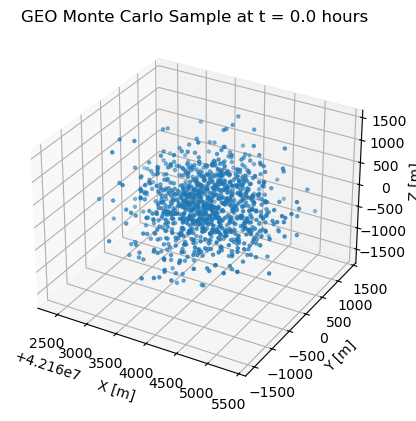

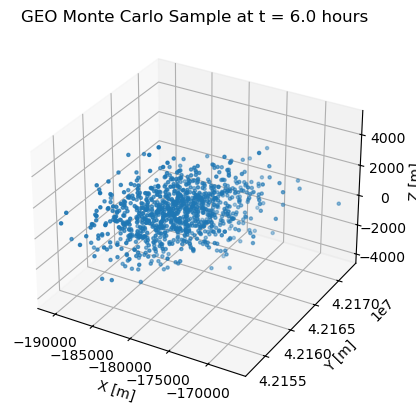

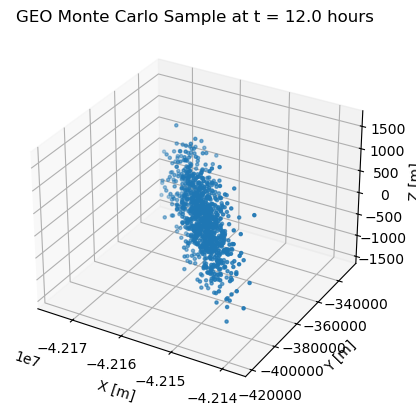

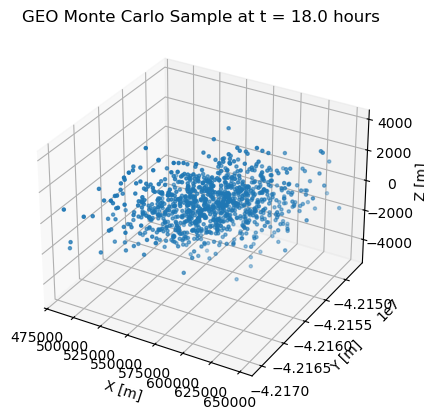

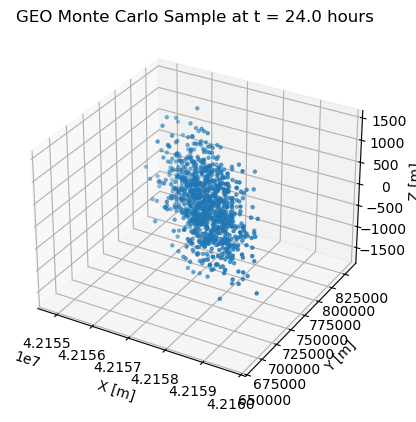

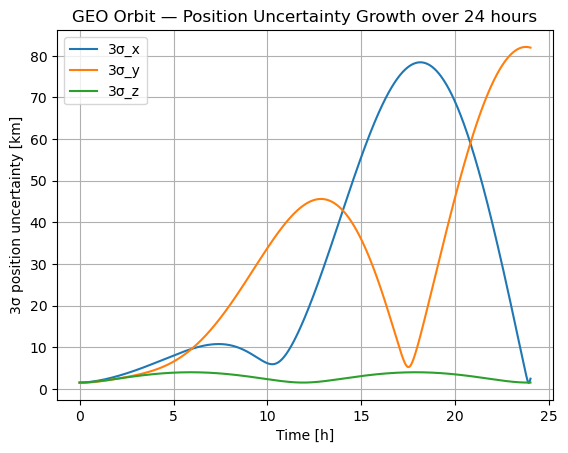

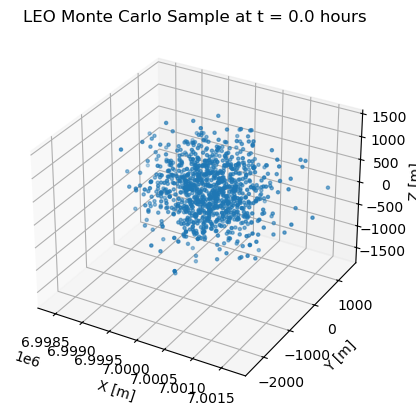

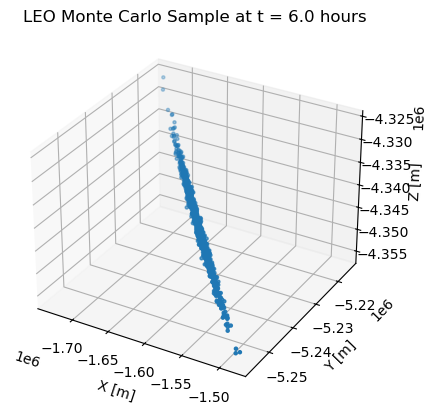

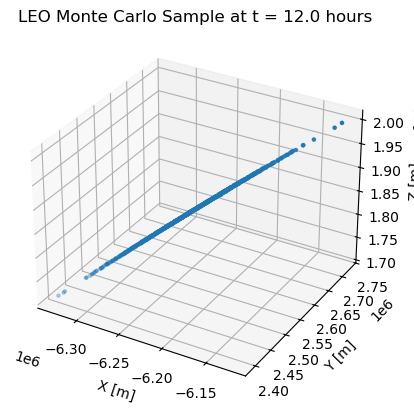

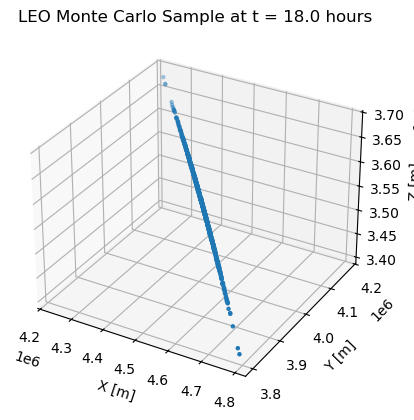

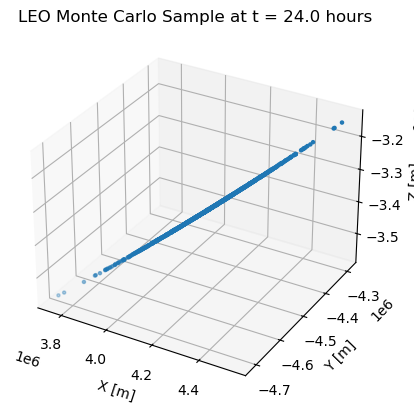

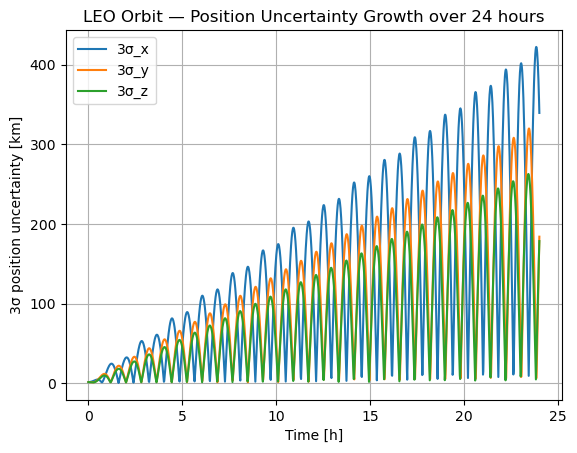

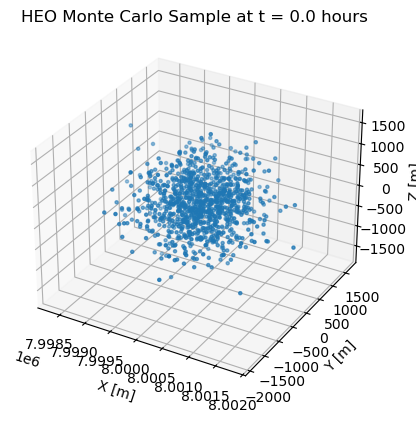

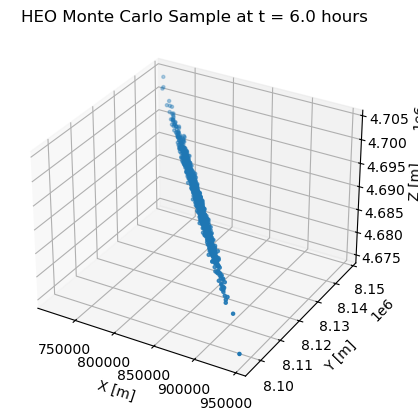

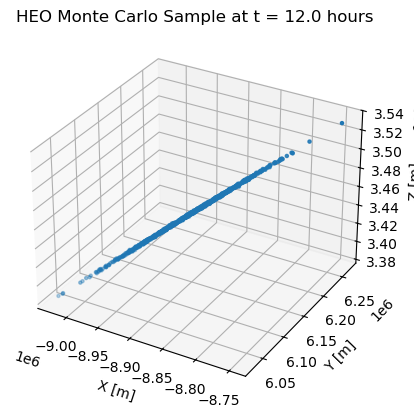

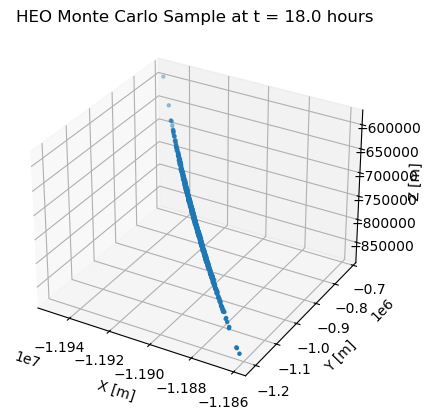

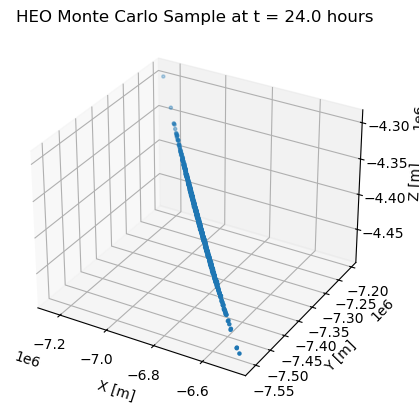

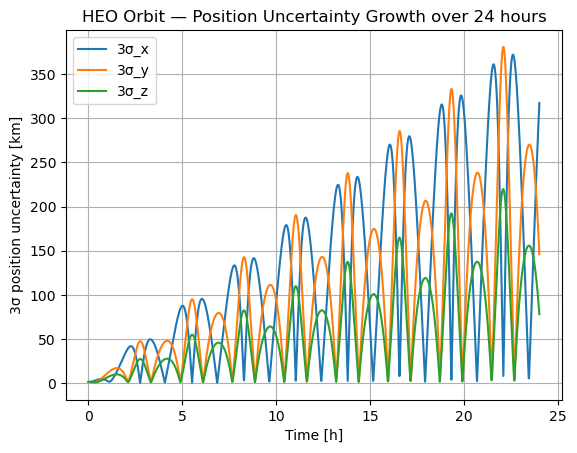

In [47]:
times_to_plot = [0, 6*3600, 12*3600, 18*3600, 24*3600]

# GEO Plots

# Plot position of each Monte Carlo sample at 0, 6, 12, 18, 24 hours
#  and compute the sample mean and covariance

pos_abs_GEO = GEO_results[:, :3, :] # (N, 3, K)

means_GEO = []

for T in times_to_plot:
    k = np.argmin(np.abs(t_span - T))

    pos = pos_abs_GEO[:,:,k] # (N, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:,0], pos[:,1], pos[:, 2], s=5)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z [m]")
    plt.title(f"GEO Monte Carlo Sample at t = {T/3600} hours")
    plt.show()

    means_GEO.append(np.mean(pos, axis=0))

sigmas_over_time_GEO = np.zeros((len(t_span), 3))

for k in range(len(t_span)):
    pos_k = pos_abs_GEO[:,:,k]      # (N,3)
    Pk = np.cov(pos_k.T)        # (3×3 covariance matrix)
    sigmas_over_time_GEO[k] = np.sqrt(np.diag(Pk)) /1000.0

plt.plot(t_span/3600, 3*sigmas_over_time_GEO[:,0], label="3σ_x")
plt.plot(t_span/3600, 3*sigmas_over_time_GEO[:,1], label="3σ_y")
plt.plot(t_span/3600, 3*sigmas_over_time_GEO[:,2], label="3σ_z")

plt.xlabel("Time [h]")
plt.ylabel("3σ position uncertainty [km]")
plt.title("GEO Orbit — Position Uncertainty Growth over 24 hours")
plt.legend()
plt.grid(True)
plt.show()

# LEO Plots

# Plot position of each Monte Carlo sample at 0, 6, 12, 18, 24 hours
#  and compute the sample mean and covariance

pos_abs_LEO = LEO_results[:, :3, :] # (N, 3, K)

means_LEO = []

for T in times_to_plot:
    k = np.argmin(np.abs(t_span - T))

    pos = pos_abs_LEO[:,:,k] # (N, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:,0], pos[:,1], pos[:, 2], s=5)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z [m]")
    plt.title(f"LEO Monte Carlo Sample at t = {T/3600} hours")
    plt.show()

    means_LEO.append(np.mean(pos, axis=0))

sigmas_over_time_LEO = np.zeros((len(t_span), 3))

for k in range(len(t_span)):
    pos_k = pos_abs_LEO[:,:,k]      # (N,3)
    Pk = np.cov(pos_k.T)        # (3×3 covariance matrix)
    sigmas_over_time_LEO[k] = np.sqrt(np.diag(Pk)) / 1000.0

plt.plot(t_span/3600, 3*sigmas_over_time_LEO[:,0], label="3σ_x")
plt.plot(t_span/3600, 3*sigmas_over_time_LEO[:,1], label="3σ_y")
plt.plot(t_span/3600, 3*sigmas_over_time_LEO[:,2], label="3σ_z")

plt.xlabel("Time [h]")
plt.ylabel("3σ position uncertainty [km]")
plt.title("LEO Orbit — Position Uncertainty Growth over 24 hours")
plt.legend()
plt.grid(True)
plt.show()

times_to_plot = [0, 6*3600, 12*3600, 18*3600, 24*3600]

# HEO Plots

# Plot position of each Monte Carlo sample at 0, 6, 12, 18, 24 hours
#  and compute the sample mean and covariance

pos_abs_HEO = HEO_results[:, :3, :] # (N, 3, K)

means_HEO = []

for T in times_to_plot:
    k = np.argmin(np.abs(t_span - T))

    pos = pos_abs_HEO[:,:,k] # (N, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:,0], pos[:,1], pos[:, 2], s=5)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_zlabel("Z [m]")
    plt.title(f"HEO Monte Carlo Sample at t = {T/3600} hours")
    plt.show()

    means_HEO.append(np.mean(pos, axis=0))

sigmas_over_time_HEO = np.zeros((len(t_span), 3))

for k in range(len(t_span)):
    pos_k = pos_abs_HEO[:,:,k]      # (N,3)
    Pk = np.cov(pos_k.T)        # (3×3 covariance matrix)
    sigmas_over_time_HEO[k] = np.sqrt(np.diag(Pk)) / 1000.0

plt.plot(t_span/3600, 3*sigmas_over_time_HEO[:,0], label="3σ_x")
plt.plot(t_span/3600, 3*sigmas_over_time_HEO[:,1], label="3σ_y")
plt.plot(t_span/3600, 3*sigmas_over_time_HEO[:,2], label="3σ_z")

plt.xlabel("Time [h]")
plt.ylabel("3σ position uncertainty [km]")
plt.title("HEO Orbit — Position Uncertainty Growth over 24 hours")
plt.legend()
plt.grid(True)
plt.show()

## 4.1.3 d/e) Runge-Kutta Results Comparison With propagate_keplerian_motion and solve_ivp

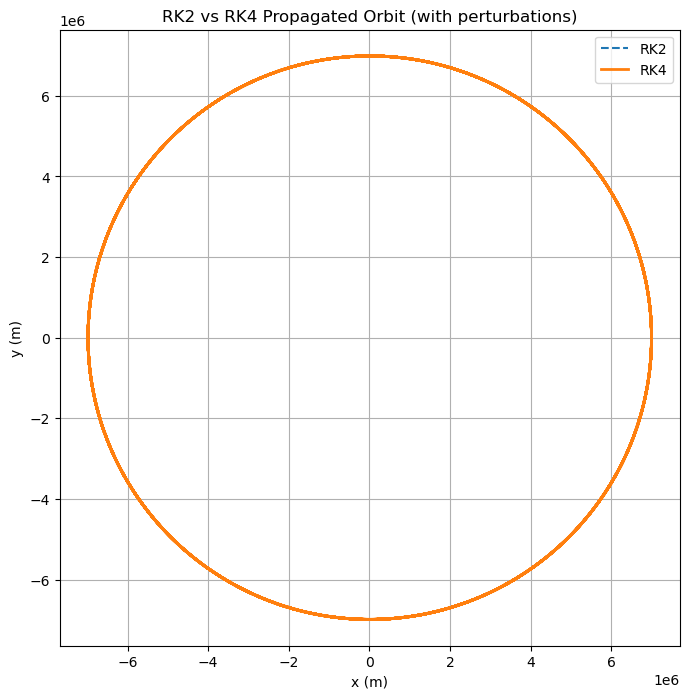

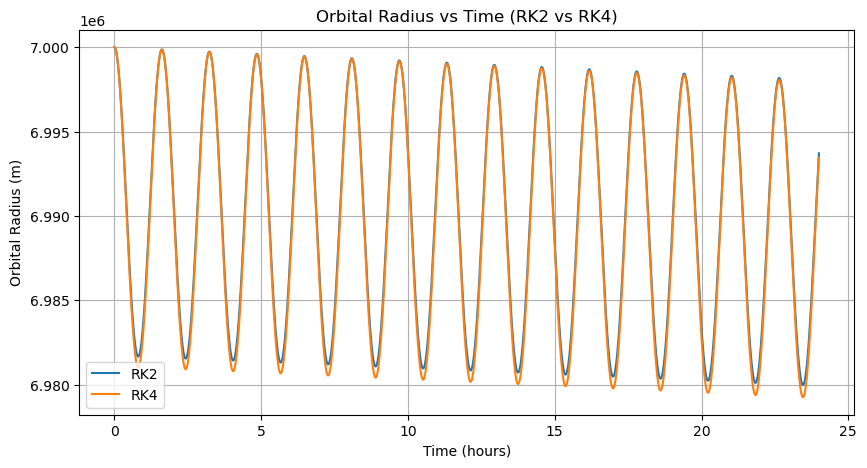

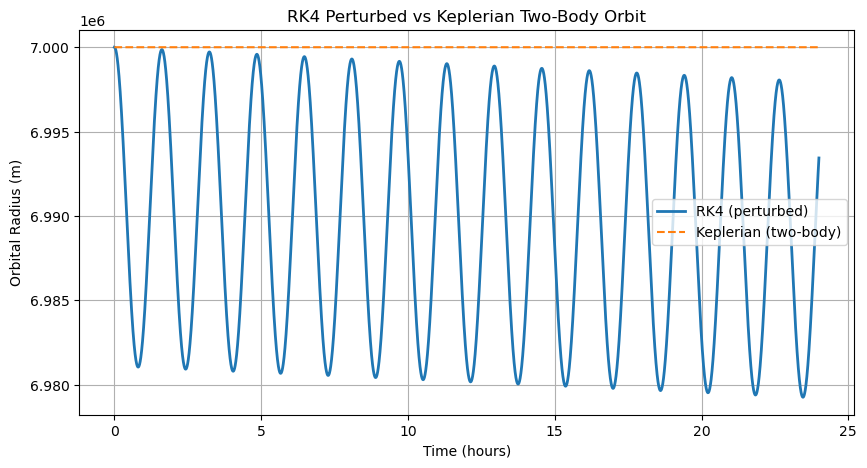

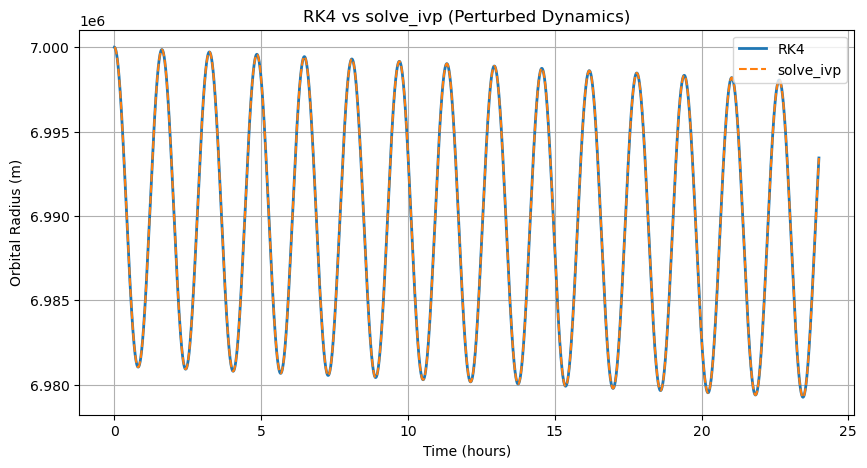

In [48]:
t0 = 0.0
tf = 24.0*3600.0
h = 10.0

y0 = np.zeros(6)
y0[:3] = np.array([7000e3, 0, 0])
y0[3:] = np.array([0, np.sqrt(MU_EARTH / 7000e3), 0])

pert = Perturbations(
    mu = MU_EARTH,
    Re = R_EARTH,
    J_2 = J_2,
    A_m = A_M,
    Cd = C_D,
    Cr = C_R,
    mu_sun = MU_SUN,
    mu_moon = MU_MOON
)

t_rk2, y_rk2 = rk2_propagation(
    lambda t, y: two_body_equation(t, y, pert),
    t0, tf, y0, h
)

t_rk4, y_rk4 = rk4_propagation(
    lambda t, y: two_body_equation(t, y, pert),
    t0, tf, y0, h
)

plt.figure(figsize=(8,8))
plt.plot(y_rk2[:,0], y_rk2[:,1], label="RK2", linestyle="--")
plt.plot(y_rk4[:,0], y_rk4[:,1], label="RK4", linewidth=2)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("RK2 vs RK4 Propagated Orbit (with perturbations)")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()

r_rk2 = norm(y_rk2[:,:3], axis=1)
r_rk4 = norm(y_rk4[:,:3], axis=1)

plt.figure(figsize=(10,5))
plt.plot(t_rk2/3600, r_rk2, label="RK2")
plt.plot(t_rk4/3600, r_rk4, label="RK4")
plt.xlabel("Time (hours)")
plt.ylabel("Orbital Radius (m)")
plt.title("Orbital Radius vs Time (RK2 vs RK4)")
plt.legend()
plt.grid(True)
plt.show()

r_kep, v_kep = propagate_keplerian_motion(t_rk4, y0)

r_kep_norm = norm(r_kep, axis=1)

plt.figure(figsize=(10,5))
plt.plot(t_rk4/3600, r_rk4, label="RK4 (perturbed)", linewidth=2)
plt.plot(t_rk4/3600, r_kep_norm, label="Keplerian (two-body)", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Orbital Radius (m)")
plt.title("RK4 Perturbed vs Keplerian Two-Body Orbit")
plt.legend()
plt.grid(True)
plt.show()

y_ivp, t_ivp = solve_ivp_propagation(
    lambda t, y: two_body_equation(t, y, pert),
    t_rk4, y0
)

r_ivp = norm(y_ivp[:,:3], axis=1)

plt.figure(figsize=(10,5))
plt.plot(t_rk4/3600, r_rk4, label="RK4", linewidth=2)
plt.plot(t_rk4/3600, r_ivp, label="solve_ivp", linestyle="--")
plt.xlabel("Time (hours)")
plt.ylabel("Orbital Radius (m)")
plt.title("RK4 vs solve_ivp (Perturbed Dynamics)")
plt.legend()
plt.grid(True)
plt.show()

## 4.1.4 c/d) Runge-Kutta Comparison Propagating gauss_variational vs. two_body_equation Over 24 hours With All Perturbations

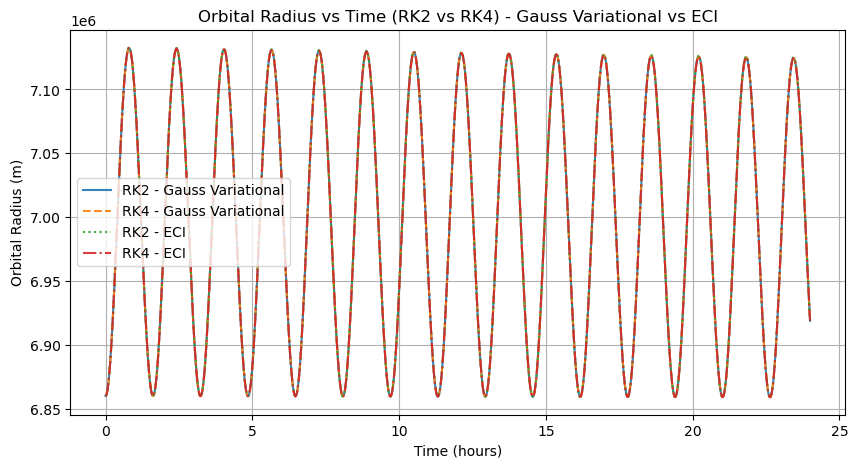

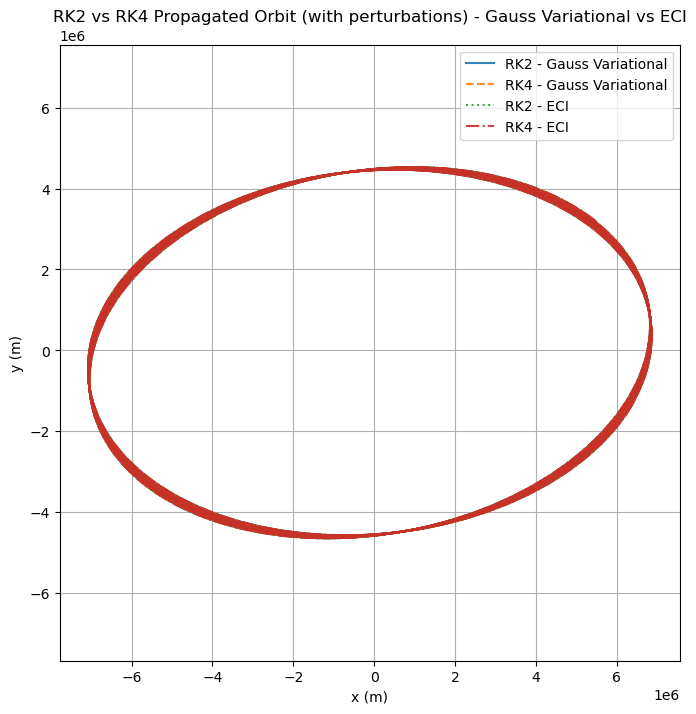

In [49]:
t0 = 0.0
tf = 24.0*3600.0
h = 10.0

a0     = 7000e3        
e0     = 0.02            
inc0   = np.deg2rad(50)  
raan0  = np.deg2rad(10)
omega0 = np.deg2rad(30)
nu0    = np.deg2rad(0)

y0_kep = np.array([a0, e0, inc0, raan0, omega0, nu0])

pert = Perturbations(
    mu = MU_EARTH,
    Re = R_EARTH,
    J_2 = J_2,
    A_m = A_M,
    Cd = C_D,
    Cr = C_R,
    mu_sun = MU_SUN,
    mu_moon = MU_MOON
)

rk2 = rk2_propagation(
    lambda t, y: gauss_variational(t, y, pert),
    t0, tf, y0_kep, h
)
t_rk2 = rk2[0]
r_rk2 = np.zeros((len(t_rk2), 3))
for i in range(len(t_rk2)):
    a2, e2, inc2, raan2, omega2, nu2 = rk2[1][i]
    r_rk2[i] = keplerian_elements_to_eci(a2, e2, inc2, raan2, omega2, nu2)[0]

rk4 = rk4_propagation(
    lambda t, y: gauss_variational(t, y, pert),
    t0, tf, y0_kep, h
)
t_rk4 = rk4[0]
r_rk4 = np.zeros((len(t_rk4), 3))
for i in range(len(t_rk4)):
    a4, e4, inc4, raan4, omega4, nu4 = rk4[1][i]
    r_rk4[i] = keplerian_elements_to_eci(a4, e4, inc4, raan4, omega4, nu4)[0]

y0 = np.zeros(6)
y0[:3] = keplerian_elements_to_eci(
    y0_kep[0], y0_kep[1], y0_kep[2], y0_kep[3], y0_kep[4], y0_kep[5]
)[0]
y0[3:] = keplerian_elements_to_eci(
    y0_kep[0], y0_kep[1], y0_kep[2], y0_kep[3], y0_kep[4], y0_kep[5]
)[1]

t_rk2_eci, y_rk2_eci = rk2_propagation(
    lambda t, y: two_body_equation(t, y, pert),
    t0, tf, y0, h
)

t_rk4_eci, y_rk4_eci = rk4_propagation(
    lambda t, y: two_body_equation(t, y, pert),
    t0, tf, y0, h
)

r_rk2_norm = norm(r_rk2, axis=1)
r_rk4_norm = norm(r_rk4, axis=1)
r_rk2_eci_norm = norm(y_rk2_eci[:,:3], axis=1)
r_rk4_eci_norm = norm(y_rk4_eci[:,:3], axis=1)

plt.figure(figsize=(10,5))
plt.plot(t_rk2/3600, r_rk2_norm, label="RK2 - Gauss Variational", linestyle="-", alpha=0.9)
plt.plot(t_rk4/3600, r_rk4_norm, label="RK4 - Gauss Variational", linestyle="--", alpha=0.9)
plt.plot(t_rk4_eci/3600, r_rk2_eci_norm, label="RK2 - ECI", linestyle=":", alpha=0.9)
plt.plot(t_rk4_eci/3600, r_rk4_eci_norm, label="RK4 - ECI", linestyle="-.", alpha=0.9)
plt.xlabel("Time (hours)")
plt.ylabel("Orbital Radius (m)")
plt.title("Orbital Radius vs Time (RK2 vs RK4) - Gauss Variational vs ECI")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,8))
plt.plot(r_rk2[:,0], r_rk2[:,1], label="RK2 - Gauss Variational", linestyle="-", alpha=0.9)
plt.plot(r_rk4[:,0], r_rk4[:,1], label="RK4 - Gauss Variational", linestyle="--", alpha=0.9)
plt.plot(y_rk2_eci[:,0], y_rk2_eci[:,1], label="RK2 - ECI", linestyle=":", alpha=0.9)
plt.plot(y_rk4_eci[:,0], y_rk4_eci[:,1], label="RK4 - ECI", linestyle="-.", alpha=0.9)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("RK2 vs RK4 Propagated Orbit (with perturbations) - Gauss Variational vs ECI")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()